In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding


In [3]:
#Create A Datafream
df_metadata= pd.read_csv('/home/becode/BeCode Projects/Mole-Detection-Project/archive/HAM10000_metadata.csv', sep=',')
df_metadata.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [4]:
# Drop all NaN
df_metadata=df_metadata.dropna()
df_metadata.shape

(9958, 7)

In [5]:
#Create a dictonarie with Column 'image_id' and 'dx'
dict_im_dx=pd.Series(df_metadata.dx.values,index=df_metadata.image_id).to_dict()
#print(dict_im_dx)

In [6]:
# Import your chosen model!
from tensorflow.keras.applications.resnet50 import ResNet50

# Make a model object. Make sure you include the top as well!
model = ResNet50(weights='imagenet')

# Look at the model architecture.
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
# Import the keras preprocessing method.
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Load your image. Make sure it is loaded in with the right dimensions for your model!
image_size = (224, 224)
original_image = image.load_img("/home/becode/BeCode Projects/Mole-Detection-Project/archive/HAM10000_images_part_1/ISIC_0024306.jpg", target_size=image_size)

# Convert your image pixels to a numpy array of values .
image_array = image.img_to_array(original_image)

# Reshape your image dimensions so that the colour channels correspond to what your model expects.
image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))

# Preprocess your image with preprocess_input.
prepared_image = preprocess_input(image_array)


('n03291819', 'envelope', 0.14359586)


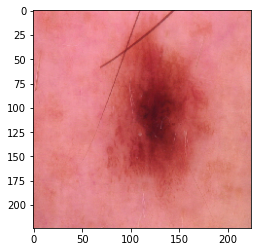

In [8]:
from tensorflow.keras.applications.resnet50 import decode_predictions
from matplotlib import pyplot as plt

# Predict the class of your picture.
prediction = model.predict(prepared_image)

# Decode your prediction into a set of human readable labels.
labels = decode_predictions(prediction)

# Get the most likely result from your set of labels.
label = labels[0][0]

# Print out your result.
print(label)

# Show handsome rick.
plt.imshow(original_image)
plt.show()

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import os

def get_preprocessed_images(images_directory: str, image_size: tuple) -> list:
    images = []
    targets=[]
    for img in os.listdir(images_directory)[:500]:
        img_without_extension =img.split(".")[0]
        target=dict_im_dx.get(img_without_extension)
        targets.append(target)
        img = image.load_img(images_directory+img, target_size=image_size)
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        images.append(img)
    return np.vstack(images), targets

In [10]:
# Import the keras preprocessing method.
from tensorflow.keras.preprocessing import image

# Load your images and preprocess them.
final_images1, targets1 = get_preprocessed_images("/home/becode/BeCode Projects/Mole-Detection-Project/archive/HAM10000_images_part_1/", image_size)
final_images2, targets2 = get_preprocessed_images("/home/becode/BeCode Projects/Mole-Detection-Project/archive/HAM10000_images_part_2/", image_size)


# Concatenate your images and your labels into X and y.
X = np.concatenate([final_images1, final_images2])
y = np.concatenate([targets1, targets2])


In [11]:
print(X.shape, y.shape)

(1000, 224, 224, 3) (1000,)


In [12]:
#print(y)

In [13]:
# create dummy variables
y=pd.get_dummies(y)
print(y)

     akiec  bcc  bkl  df  mel  nv  vasc
0        0    0    0   0    0   1     0
1        0    0    0   0    0   1     0
2        0    0    0   0    0   1     0
3        0    0    0   0    0   1     0
4        0    0    1   0    0   0     0
..     ...  ...  ...  ..  ...  ..   ...
995      0    0    0   0    0   1     0
996      0    0    0   0    0   1     0
997      0    0    0   0    0   1     0
998      0    1    0   0    0   0     0
999      0    0    0   0    1   0     0

[1000 rows x 7 columns]


In [14]:

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Determine the number of generated samples you want per original sample.
datagen_batch_size = 32

# Make a datagenerator object using ImageDataGenerator.
train_datagen = ImageDataGenerator(rotation_range=60,
                                    horizontal_flip=True)

# Feed the generator your train data.
train_generator = train_datagen.flow(X_train, y_train, batch_size=datagen_batch_size)

# Make a datagenerator object using ImageDataGenerator.
validation_datagen = ImageDataGenerator(rotation_range=60,
                                        horizontal_flip=True)

# Feed the generator your validation data.
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=datagen_batch_size)

In [16]:
# Import your chosen model!
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Make a model object. 
# Make sure you exclude the top part. set the input shape of the model to 224x224 pixels, with 3 color channels.
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the imported layers so they cannot be retrained.
for layer in model.layers:
    layer.trainable = False
    
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(7, activation='softmax'))

# Summarize.
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7)                 6272583   
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 6,273,550
Trainable params: 6,239,438
Non-trainable params: 34,112
_________________________________________________________________


In [23]:
# Compile and fit the model. Use the Adam optimizer and crossentropical loss. 
# Use the validation data argument during fitting to include your validation data.
new_model.compile(optimizer='adam',
                  loss='CategoricalCrossentropy',
                  metrics=['accuracy'])
history = new_model.fit(train_generator,
                        epochs=5, 
                        batch_size=8,
                        validation_data=validation_generator
                       )

Epoch 1/5
16/20 [=======================>......] - ETA: 50s - loss: 1.7656 - accuracy: 0.3984 

In [1]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow import keras

image_size = (224, 224)
original_image = image.load_img('images/image',target_size=image_size)

# Convert your image pixels to a numpy array of values .
image_array = image.img_to_array(original_image)

# Reshape your image dimensions so that the colour channels correspond to what your model expects.
image_array = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))

# Preprocess your image with preprocess_input.
prepared_image = preprocess_input(image_array)
# print(image)            
#image.save(os.path.join(app.config["IMAGE_UPLOADS"], image.filename))       
# Loading model to compare the results
model = keras.models.load_model('/home/becode/BeCode Projects/Mole-Detection-Project/Model')                    
            
# Predict the class of your picture.
prediction = model.predict(prepared_image)


2022-05-24 09:49:23.491800: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-24 09:49:23.537247: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2494245000 Hz
2022-05-24 09:49:23.537902: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557631eec130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-24 09:49:23.537934: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [5]:
print(prediction)

[[0.13908644 0.13749044 0.15356347 0.13400497 0.14457852 0.15669487
  0.13458131]]


In [32]:
import numpy as np
final_prediction=prediction.max()
print(final_prediction)
#final_predition_index=prediction.index(final_prediction)
#print(final_predition_index)
final_mole_id=np.where(prediction [0]== final_prediction)
x= final_mole_id[0][0]
print(x)

0.15669487
5


In [35]:
dict = {
        0: 'Actinic keratoses (akiec)',
        1: 'Basal cell carcinoma (bcc)',
        2: 'Benign keratosis-like lesions (bkl)',
        3: 'Dermatofibroma (df)',
        4: 'Melanoma (mel)',
        5: 'Melanocytic nevi (nv)',
        6: 'Vascular lesions (vasc)'}

predicted_mole_name=dict[x]
               
print(predicted_mole_name)


Melanocytic nevi (nv)


In [21]:
final_model = new_model # Get model (Sequential, Functional Model, or Model subclass)
final_model.save('/home/becode/BeCode Projects/Mole-Detection-Project/Model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-05-24 09:39:57.291351: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/becode/BeCode Projects/Mole-Detection-Project/Model/assets
